# Ports Notebook

The objective of this analysis is to examine the impact of the Red Sea Conflict on maritime trade statistics derived from AIS data.  

We process transit calls and estimated trade volume from the IMF's [PortWatch](https://portwatch.imf.org/) platform for key ports of interest. We then produce charts to inspect trends and calculate percentage changes from a historical baseline.

## Setup

Import libraries and define output paths to save graphs and tables.

In [1]:
import os
from os.path import join, exists

import pandas as pd
import geopandas as gpd

import git
import time

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")
from red_sea_monitoring.utils import *

# For plotting
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format, comma_format, percent_format
import plotnine

# plotnine.options.figure_size = (10, 8)
plotnine.options.figure_size = (5, 4)

output_dir = (
    r"C:\Users\WB514197\WBG\Development Data Partnership - Red Sea Maritime Monitoring"
)
charts_dir = join(git_root, "reports")

## Data

### Ports

In [2]:
# ports = get_ports()
countries = ["Egypt", "Yemen", "Djibouti", "Jordan", "Saudi Arabia"]
# ports_sel = ports.loc[ports.country.isin(countries)].copy()
# ports_sel.sort_values("country", inplace=True)
# ports_sel.loc[:, "geometry"] = ports_sel.apply(lambda x: Point(x.lon, x.lat), axis=1)
# ports_gdf = gpd.GeoDataFrame(ports_sel, geometry="geometry", crs="EPSG:4326")
# ports_gdf.to_file(join(git_root, "data", "ports_sel.geojson"), driver='GeoJSON'))
ports_red_sea = gpd.read_file(
    join(git_root, "data", "red_sea_ports.geojson"), driver="GeoJSON"
)

In [3]:
ports_red_sea[["country", "portname", "portid"]]

,country,portname,portid
0,Djibouti,Djibouti,port294
1,Egypt,El-Adabiya,port321
2,Egypt,Safaga,port191
3,Egypt,North Ain Sukhna Port,port828
4,Egypt,As Suways,port71
5,Jordan,Al Aqabah,port19
6,Saudi Arabia,Duba Bulk Plant Tanker Terminal,port305
7,Saudi Arabia,Rabigh,port1081
8,Saudi Arabia,King Fahd Port,port570
9,Saudi Arabia,Duba,port304


### Map of Ports

In [4]:
ports_red_sea[
    [
        "geometry",
        "portname",
        "country",
        "vessel_count_total",
        "vessel_count_container",
        "vessel_count_dry_bulk",
        "vessel_count_general_cargo",
        "vessel_count_RoRo",
        "vessel_count_tanker",
        "industry_top1",
        "industry_top2",
        "industry_top3",
        "share_country_maritime_import",
        "share_country_maritime_export",
    ]
].explore(
    column="country",
    cmap="Dark2",
    marker_kwds={"radius": 7},
    tiles="Esri.WorldGrayCanvas",
    legend_kwds={"loc": "upper right", "caption": "Ports"},
    # attribution = 'chec'
)

### Trade Data

Pull trade data for selected locations.

In [5]:
ports = list(ports_red_sea.portid)
df_ports = get_port_data(ports)
df_ports.to_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'ports_data_{time.strftime("%Y_%m_%d")}.csv',
    ),
    index=False,
)

## Data Analysis

### Convert to Weekly

In [8]:
df = pd.read_csv(
    join(
        output_dir,
        "data",
        "PortWatch-data",
        f'ports_data_{time.strftime("%Y_%m_%d")}.csv',
    )
)
df.date = pd.to_datetime(df.date)
df = df.loc[df.date >= "2019-01-01"].copy()

In [10]:
df.tail(2)

,date,year,month,day,portid,portname,country,ISO3,portcalls_container,portcalls_dry_bulk,...,import_cargo,import,export_container,export_dry_bulk,export_general_cargo,export_roro,export_tanker,export_cargo,export,ObjectId
33598,2024-09-28 20:00:00,2024,9,29,port9,Aden,Yemen,YEM,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3227966
33599,2024-09-29 20:00:00,2024,9,30,port9,Aden,Yemen,YEM,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3227967


Calculate weekly sums.

In [11]:
df = df[
    [
        "portid",
        "portname",
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
        "date",
    ]
].copy()
df_raw = df.copy()

df = (
    df.groupby(["portname", "portid"])[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("W-Mon", on="date")
    .sum()
    .reset_index()
)

df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "w"] = df.date.dt.strftime("%W")

In [12]:
df.head(2)

,portname,portid,date,portcalls_cargo,portcalls_tanker,portcalls,import_cargo,export_cargo,import_tanker,export_tanker,import,export,ymd,w
0,Aden,port9,2019-01-07,9,1,10,67364.559011,6774.851456,0.0,0.0,67364.559011,6774.851456,2019-01-07,01
1,Aden,port9,2019-01-14,9,0,9,57414.729623,0.000000,0.0,0.0,57414.729623,0.000000,2019-01-14,02


### Plot Weekly Trade Volume

In [13]:
# start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [14]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()

In [15]:
charts_by_port_dir = join(charts_dir, "ports")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

In [16]:
start_reference_date = "2022-01-01"
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = df_ref.groupby(["portname", "portid", "w"])[
    [
        "portcalls_cargo",
        "portcalls_tanker",
        "portcalls",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
].mean()
df_ref.reset_index(inplace=True)
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)
df_filt = df_filt.merge(
    df_ref, on=["portname", "portid", "w"], how="left", validate="m:1"
)

In [19]:
for port_id in df_filt.portid.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portid == port_id].iloc[0]
    country = port_info.country
    df_port = df_filt.loc[df_filt.portid == port_id].copy()
    df_port_copy = df_port.copy()
    port = df_port_copy.iloc[0].portname
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p0 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="#00BFC4", size=1, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="#F8766D", size=1, alpha=3 / 4
        )
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="",
            subtitle="Metric Tons",
            title=f"Weekly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(
            text=element_text(family="Roboto", size=13),
            plot_title=element_text(family="Roboto", size=16, weight="bold"),
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position="none",
        )
        + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
    )
    # display(p0)
    p0.save(
        filename=join(charts_by_port_dir, f"estimated-trade-{port_id}.jpeg"), dpi=300
    )

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports\estimated-trade-port9.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports\estimated-trade-port321.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineW

### Resample to Monthly

In [20]:
df = (
    df_raw.groupby(["portname", "portid"])[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
            "date",
        ]
    ]
    .resample("MS", on="date")
    .sum()
    .reset_index()
)
df.loc[:, "ymd"] = df.date.dt.strftime("%Y-%m-%d")
df.loc[:, "m"] = df.date.dt.strftime("%m")

In [21]:
df = df.loc[df.date < "2024-10-01"].copy()

### Calculate Reference Values

Periods
- **Baseline**: 2021, 2022, 2023 (January 1st – October 6th)
- **Middle East Conflict**: 2023 (October 7th - November 16th)
- **Red Sea Crisis**: November 17th - January 31st, 2024

In [22]:
start_reference_date = "2022-01-01"
conflict_date = "2023-10-07"
crisis_date = "2023-11-17"

In [23]:
df_ref = df.loc[(df.date >= start_reference_date) & (df.date < conflict_date)].copy()
df_ref = (
    df_ref.groupby(["portid", "portname", "m"])[
        [
            "portcalls_cargo",
            "portcalls_tanker",
            "portcalls",
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
        ]
    ]
    .mean()
    .reset_index()
)
df_ref.rename(
    columns={
        "portcalls_cargo": "portcalls_cargo_ref",
        "portcalls_tanker": "portcalls_tanker_ref",
        "portcalls": "portcalls_ref",
        "import_cargo": "import_cargo_ref",
        "export_cargo": "export_cargo_ref",
        "import_tanker": "import_tanker_ref",
        "export_tanker": "export_tanker_ref",
        "import": "import_ref",
        "export": "export_ref",
    },
    inplace=True,
)

Filter recent data (2023 onwards) and merge reference values.

In [24]:
df_filt = df.loc[(df.date >= "2023-01-01")].copy()
df_filt = df_filt.merge(
    df_ref, on=["portid", "portname", "m"], how="left", validate="m:1"
)

In [25]:
charts_by_port_dir = join(charts_dir, "ports-ref-monthly")
if not exists(charts_by_port_dir):
    os.makedirs(charts_by_port_dir, mode=0o777)

### Plot Monthly Trade Volume and Historical Average

In [26]:
for port_id in df_filt.portid.unique():
    port_info = ports_red_sea.loc[ports_red_sea.portid == port_id].iloc[0]
    country = port_info.country
    df_port = df_filt.loc[df_filt.portid == port_id].copy()
    port = df_port.iloc[0].portname
    df_port_copy = df_port.copy()
    df_port = df_port.melt(
        id_vars="date",
        value_vars=["import", "export"],
        var_name="direction",
        value_name="trade",
    )
    df_port.loc[:, "direction"] = df_port.direction.str.capitalize()
    p1 = (
        ggplot(df_port_copy, aes(x="date", y="import_ref"))  #
        + geom_bar(
            mapping=aes(x="date", y="trade", fill="direction"),
            data=df_port,
            alpha=3 / 4,
            stat="identity",
            position="dodge2",
        )  #  fill="lightblue"
        + geom_smooth(
            mapping=aes(x="date", y="import_ref"), color="#00BFC4", size=1, alpha=3 / 4
        )
        + geom_smooth(
            mapping=aes(x="date", y="export_ref"), color="#F8766D", size=1, alpha=3 / 4
        )
        # + geom_line(aes(x="date", y="export"), alpha=1, color="darkred")
        + geom_vline(xintercept=conflict_date, linetype="dashed", color="black")
        + geom_vline(xintercept=crisis_date, linetype="dashed", color="black")
        + labs(
            x="",
            y="",
            subtitle="Metric Tons",
            title=f"Monthly Trade Volume - {port}, {country}",
            fill="Trade Flow",
        )
        + theme_minimal()
        + theme(
            text=element_text(family="Roboto", size=13),
            plot_title=element_text(family="Roboto", size=16, weight="bold"),
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position="none",
        )
        + scale_x_datetime(breaks=date_breaks("2 month"), labels=date_format("%Y-%m"))
        + scale_y_continuous(labels=comma_format())
        # + scale_fill_brewer(type='qual', palette=1)
    )
    # display(p1)
    p1.save(
        filename=join(charts_by_port_dir, f"estimated-trade-{port_id}.jpeg"), dpi=300
    )

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports-ref-monthly\estimated-trade-port9.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\ports-ref-monthly\estimated-trade-port321.jpeg
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\stats\smo

## Summary Statistics

Calculate average values by port and time period.

In [28]:
conflict_date, crisis_date

('2023-10-07', '2023-11-17')

In [29]:
df.loc[:, "period"] = ""
df.loc[
    (df.date >= start_reference_date) & (df.date < crisis_date), "period"
] = "Reference"
df.loc[
    (df.date >= conflict_date) & (df.date < crisis_date), "period"
] = "Middle East Conflict"
df.loc[(df.date >= crisis_date), "period"] = "Red Sea Crisis"
df = df.merge(ports_red_sea[["portid", "country"]], on="portid")

In [30]:
df_agg = (
    df.loc[df.period != ""]
    .groupby(["country", "portname", "period"])[
        [
            "import_cargo",
            "export_cargo",
            "import_tanker",
            "export_tanker",
            "import",
            "export",
        ]
    ]
    .mean()
)

# change order of rows
df_agg = df_agg.reindex(
    ["Reference", "Middle East Conflict", "Red Sea Crisis"], level=2
)

In [31]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

### Table: Monthly Average Values by Time Period

In [32]:
table = df_agg.copy()
table = table.applymap(lambda x: "{:,.0f}".format(x))
table.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
table.index.names = ["Country", "Port", "Period"]
table

C:\Users\WB514197\AppData\Local\Temp\ipykernel_6568\528398492.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Djibouti     Djibouti                        Reference                 479,090   
                                             Middle East Conflict      544,811   
                                             Red Sea Crisis            462,457   
Egypt        Al Adabiyah                     Reference                  64,202   
                                             Middle East Conflict       82,129   
                                             Red Sea Crisis             36,745   
             As Suways                       Reference                   5,452   
                                             Middle East Conflict        5,444   
                                             Red Sea Crisis              5,120   
             El Sokhna                       Reference                 441,979   
                                             Middle East Conflict      478,687   
                                             Red Sea Crisis            391,339   
             Safaga                          Reference                  80,013   
                                             Middle East Conflict       89,320   
                                             Red Sea Crisis             81,574   
Jordan       Al Aqabah                       Reference                 528,045   
                                             Middle East Conflict      432,173   
                                             Red Sea Crisis            242,440   
Saudi Arabia Duba                            Reference                  11,670   
                                             Middle East Conflict       10,347   
                                             Red Sea Crisis             17,617   
             Duba Bulk Plant Tanker Terminal Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             Jeddah                          Reference               1,112,810   
                                             Middle East Conflict    1,299,178   
                                             Red Sea Crisis            728,476   
             King Fahd Port                  Reference                  69,139   
                                             Middle East Conflict       44,789   
                                             Red Sea Crisis             60,095   
             Rabigh                          Reference                      70   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  2   
             Shoaiba                         Reference                       0   
                                             Middle East Conflict            0   
                                             Red Sea Crisis                  0   
             Yanbu                           Reference                 117,484   
                                             Middle East Conflict      106,580   
                                             Red Sea Crisis            114,025   
Yemen        Aden                            Reference                 250,853   
                                             Middle East Conflict      163,033   
                                             Red Sea Crisis            133,704   
             Al Mukalla                      Reference                  23,044   
                                             Middle East Conflict       17,033   
                                             Red Sea Crisis             10,512   
             Al-hudaydah                     Reference                 140,766   
                                             Middle East Conflict      231,694   
                                             Red

In [33]:
countries = list(df.country.unique())
df_agg_copy = df_agg.copy()
res = []
for country in countries:
    df_country = df_agg_copy.loc[(country), :].copy()
    aois = df_country.index.get_level_values(0).unique()
    for aoi in aois:
        df_sub = df_country.loc[(aoi), :].transpose().copy()
        df_sub.loc[:, "Middle East Conflict"] = (
            df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub.loc[:, "Red Sea Crisis"] = (
            df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
        ) / df_sub.loc[:, "Reference"]
        df_sub2 = df_sub.transpose()
        df_sub2.drop("Reference", inplace=True)
        df_sub2.loc[:, "portname"] = aoi
        df_sub2.loc[:, "country"] = country
        res.append(df_sub2)

In [34]:
df_agg_pct = pd.concat(res)
table2 = df_agg_pct.copy()

### Table: Monthly Average Values by Time Period, % Change from Baseline

In [35]:
table2.reset_index(inplace=True)
table2.set_index(["country", "portname", "period"], inplace=True)

# format columns as pct
table2 = table2.applymap(lambda x: "{:.2%}".format(x))
table2.rename(
    columns={
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
table2.index.names = ["Country", "Port", "Period"]
table2

C:\Users\WB514197\AppData\Local\Temp\ipykernel_6568\1744506812.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.


Cargo Import  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -35.01%   
                                             Red Sea Crisis            -46.70%   
             Al Mukalla                      Middle East Conflict      -26.08%   
                                             Red Sea Crisis            -54.38%   
             Al-hudaydah                     Middle East Conflict       64.60%   
                                             Red Sea Crisis             46.92%   
Egypt        Al Adabiyah                     Middle East Conflict       27.92%   
                                             Red Sea Crisis            -42.77%   
             As Suways                       Middle East Conflict       -0.14%   
                                             Red Sea Crisis             -6.09%   
             El Sokhna                       Middle East Conflict        8.31%   
                                             Red Sea Crisis            -11.46%   
             Safaga                          Middle East Conflict       11.63%   
                                             Red Sea Crisis              1.95%   
Jordan       Al Aqabah                       Middle East Conflict      -18.16%   
                                             Red Sea Crisis            -54.09%   
Djibouti     Djibouti                        Middle East Conflict       13.72%   
                                             Red Sea Crisis             -3.47%   
Saudi Arabia Duba                            Middle East Conflict      -11.33%   
                                             Red Sea Crisis             50.96%   
             Duba Bulk Plant Tanker Terminal Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             Jeddah                          Middle East Conflict       16.75%   
                                             Red Sea Crisis            -34.54%   
             King Fahd Port                  Middle East Conflict      -35.22%   
                                             Red Sea Crisis            -13.08%   
             Rabigh                          Middle East Conflict     -100.00%   
                                             Red Sea Crisis            -97.10%   
             Shoaiba                         Middle East Conflict         nan%   
                                             Red Sea Crisis               nan%   
             Yanbu                           Middle East Conflict       -9.28%   
                                             Red Sea Crisis             -2.94%   

                                                                  Cargo Export  \
Country      Port                            Period                              
Yemen        Aden                            Middle East Conflict      -64.99%   
                                             Red Sea Crisis            -44.46%   
             Al Mukalla                      Middle East Conflict      -72.68%   
                                             Red Sea Crisis            -60.99%   
             Al-hudaydah                     Middle East Conflict       60.50%   
                                             Red Sea Crisis            -19.98%   
Egypt        Al Adabiyah                     Middle East Conflict       28.39%   
                                             Red Sea Crisis            -16.58%   
             As Suways                       Middle East Conflict     -100.00%   
                                             Red Sea Crisis            -41.62%   
             El Sokhna                       Middle East Conflict       98.04%   
                                             Red Sea Crisis             20.83%   
             Safaga                          Middle East Conflict        7.57%   
                                             Re

## Parade Chart: Absolute Differences

In [36]:
countries = list(df.country.unique())
df_agg_copy = df_agg.copy()
res = []
for country in countries:
    df_country = df_agg_copy.loc[(country), :].copy()
    aois = df_country.index.get_level_values(0).unique()
    for aoi in aois:
        df_sub = df_country.loc[(aoi), :].transpose().copy()
        df_sub.loc[:, "Middle East Conflict"] = (
            df_sub.loc[:, "Middle East Conflict"] - df_sub.loc[:, "Reference"]
        )
        df_sub.loc[:, "Red Sea Crisis"] = (
            df_sub.loc[:, "Red Sea Crisis"] - df_sub.loc[:, "Reference"]
        )
        df_sub2 = df_sub.transpose()
        df_sub2.drop("Reference", inplace=True)
        df_sub2.loc[:, "portname"] = aoi
        df_sub2.loc[:, "country"] = country
        res.append(df_sub2)
df_agg_diff = pd.concat(res)

In [37]:
df_agg_diff = df_agg_diff.reset_index()
df_agg_diff = df_agg_diff.loc[df_agg_diff.period == "Red Sea Crisis"].copy()

df_agg_diff.loc[:, "import_direction"] = df_agg_diff["import"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)
df_agg_diff.loc[:, "export_direction"] = df_agg_diff["export"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)

df_agg_diff.loc[:, "import_absolute"] = df_agg_diff["import"].apply(lambda x: abs(x))
df_agg_diff.loc[:, "export_absolute"] = df_agg_diff["export"].apply(lambda x: abs(x))

df_agg_diff.sort_values("import_absolute", ascending=False, inplace=True)
df_agg_diff["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

In [43]:
plotnine.options.figure_size = (8, 6)
# plotnine.options.figure_size = (5, 4)

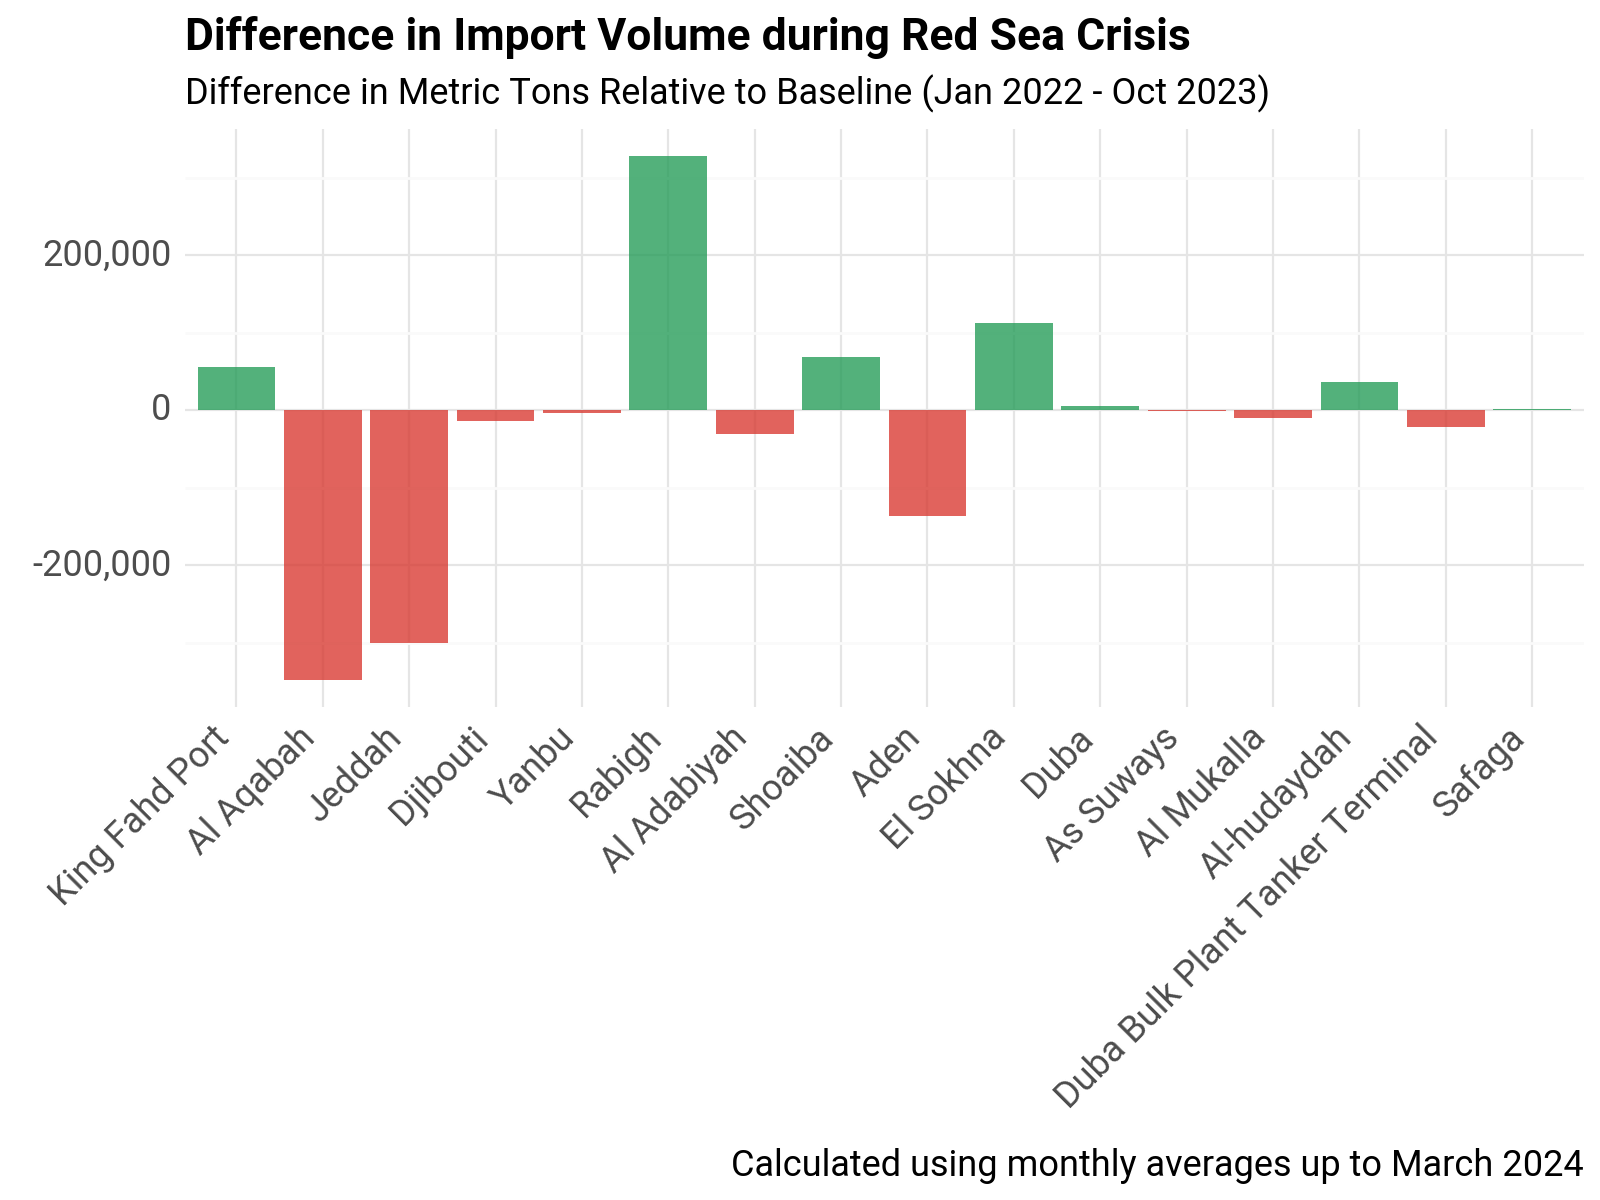

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\import-difference.jpeg


In [47]:
p2 = (
    ggplot(df_agg_diff, aes(x="portname_cat", y="import", fill="import_direction"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )
    + labs(
        x="",
        y="",
        title="Difference in Import Volume during Red Sea Crisis",
        subtitle="Difference in Metric Tons Relative to Baseline (Jan 2022 - Oct 2023)",
        caption="Calculated using monthly averages up to March 2024",
        # caption="Calculated using monthly averages during Red Sea Crisis \n(Oct, 2023 - Mar 2024) and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_y_continuous(labels=comma_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
)
display(p2)
p2.save(filename=join(charts_dir, "import-difference.jpeg"), dpi=300)

In [45]:
df_agg_diff.sort_values("export_absolute", ascending=False, inplace=True)
df_agg_diff["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

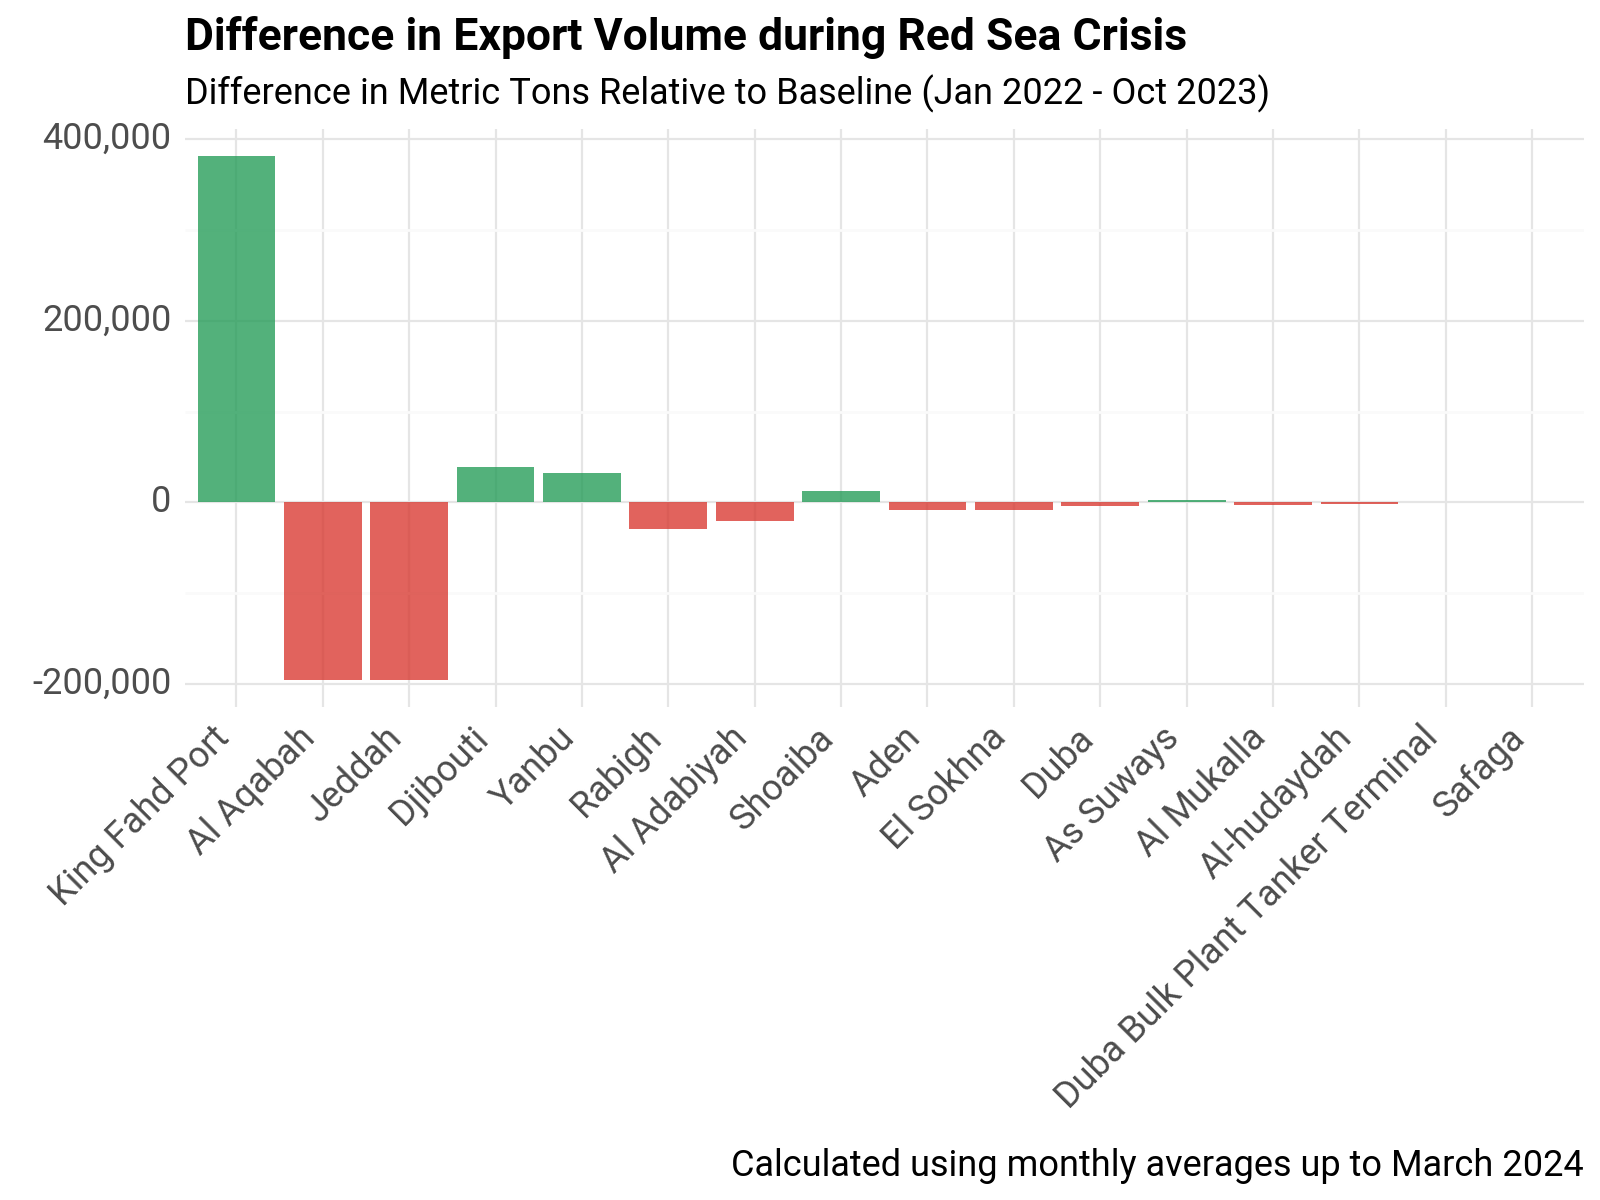

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\export-difference.jpeg


In [46]:
p2 = (
    ggplot(df_agg_diff, aes(x="portname_cat", y="export", fill="export_direction"))  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="",
        subtitle="Difference in Metric Tons Relative to Baseline (Jan 2022 - Oct 2023)",
        title="Difference in Export Volume during Red Sea Crisis",
        caption="Calculated using monthly averages up to March 2024",
        # caption="Calculated using monthly averages during Red Sea Crisis \n(Oct, 2023 - Mar 2024) and baseline period (Jan 2022 - Oct 2023)",
    )
    + theme_minimal()
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_y_continuous(labels=comma_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
)
display(p2)
p2.save(filename=join(charts_dir, "export-difference.jpeg"), dpi=300)

## Parade Chart % Diff

In [48]:
df_agg_pct_raw = df_agg_pct.reset_index()
df_agg_pct_raw = df_agg_pct_raw.loc[df_agg_pct_raw.period == "Red Sea Crisis"].copy()

df_agg_pct_raw.loc[:, "import_direction"] = df_agg_pct_raw["import"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)
df_agg_pct_raw.loc[:, "export_direction"] = df_agg_pct_raw["export"].apply(
    lambda x: "Increase" if x > 0 else "Decrease"
)

df_agg_pct_raw.loc[:, "import_absolute"] = df_agg_pct_raw["import"].apply(
    lambda x: abs(x)
)
df_agg_pct_raw.loc[:, "export_absolute"] = df_agg_pct_raw["export"].apply(
    lambda x: abs(x)
)

df_agg_pct_raw.sort_values("import_absolute", ascending=False, inplace=True)
df_agg_pct_raw["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

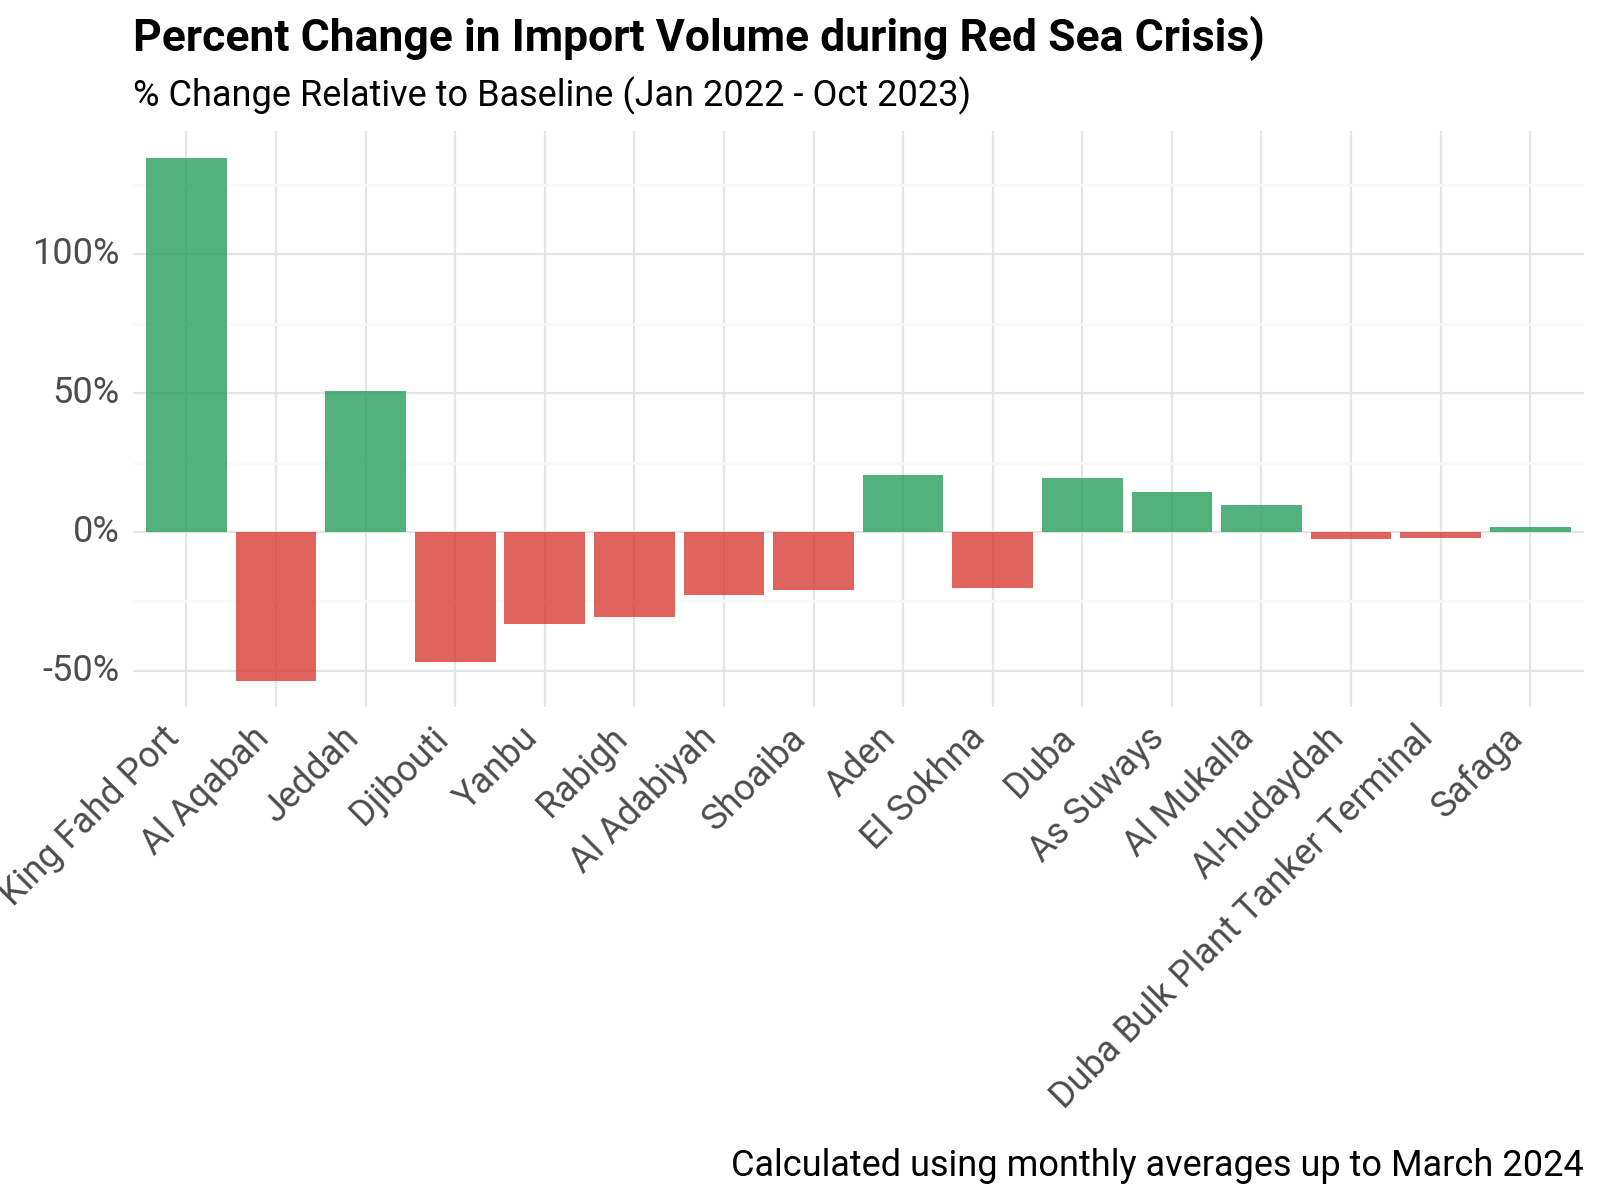

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\import-pct-change.jpeg


In [49]:
p3 = (
    ggplot(
        df_agg_pct_raw, aes(x="portname_cat", y="import", fill="import_direction")
    )  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="",
        title="Percent Change in Import Volume during Red Sea Crisis)",
        subtitle="% Change Relative to Baseline (Jan 2022 - Oct 2023)",
        caption="Calculated using monthly averages up to March 2024",
    )
    + theme_minimal()
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_y_continuous(labels=percent_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
)
display(p3)
p3.save(filename=join(charts_dir, "import-pct-change.jpeg"), dpi=300)

In [50]:
df_agg_pct_raw.sort_values("export_absolute", ascending=False, inplace=True)
df_agg_pct_raw["portname_cat"] = pd.Categorical(
    df_agg_diff.portname, categories=pd.unique(df_agg_diff.portname)
)

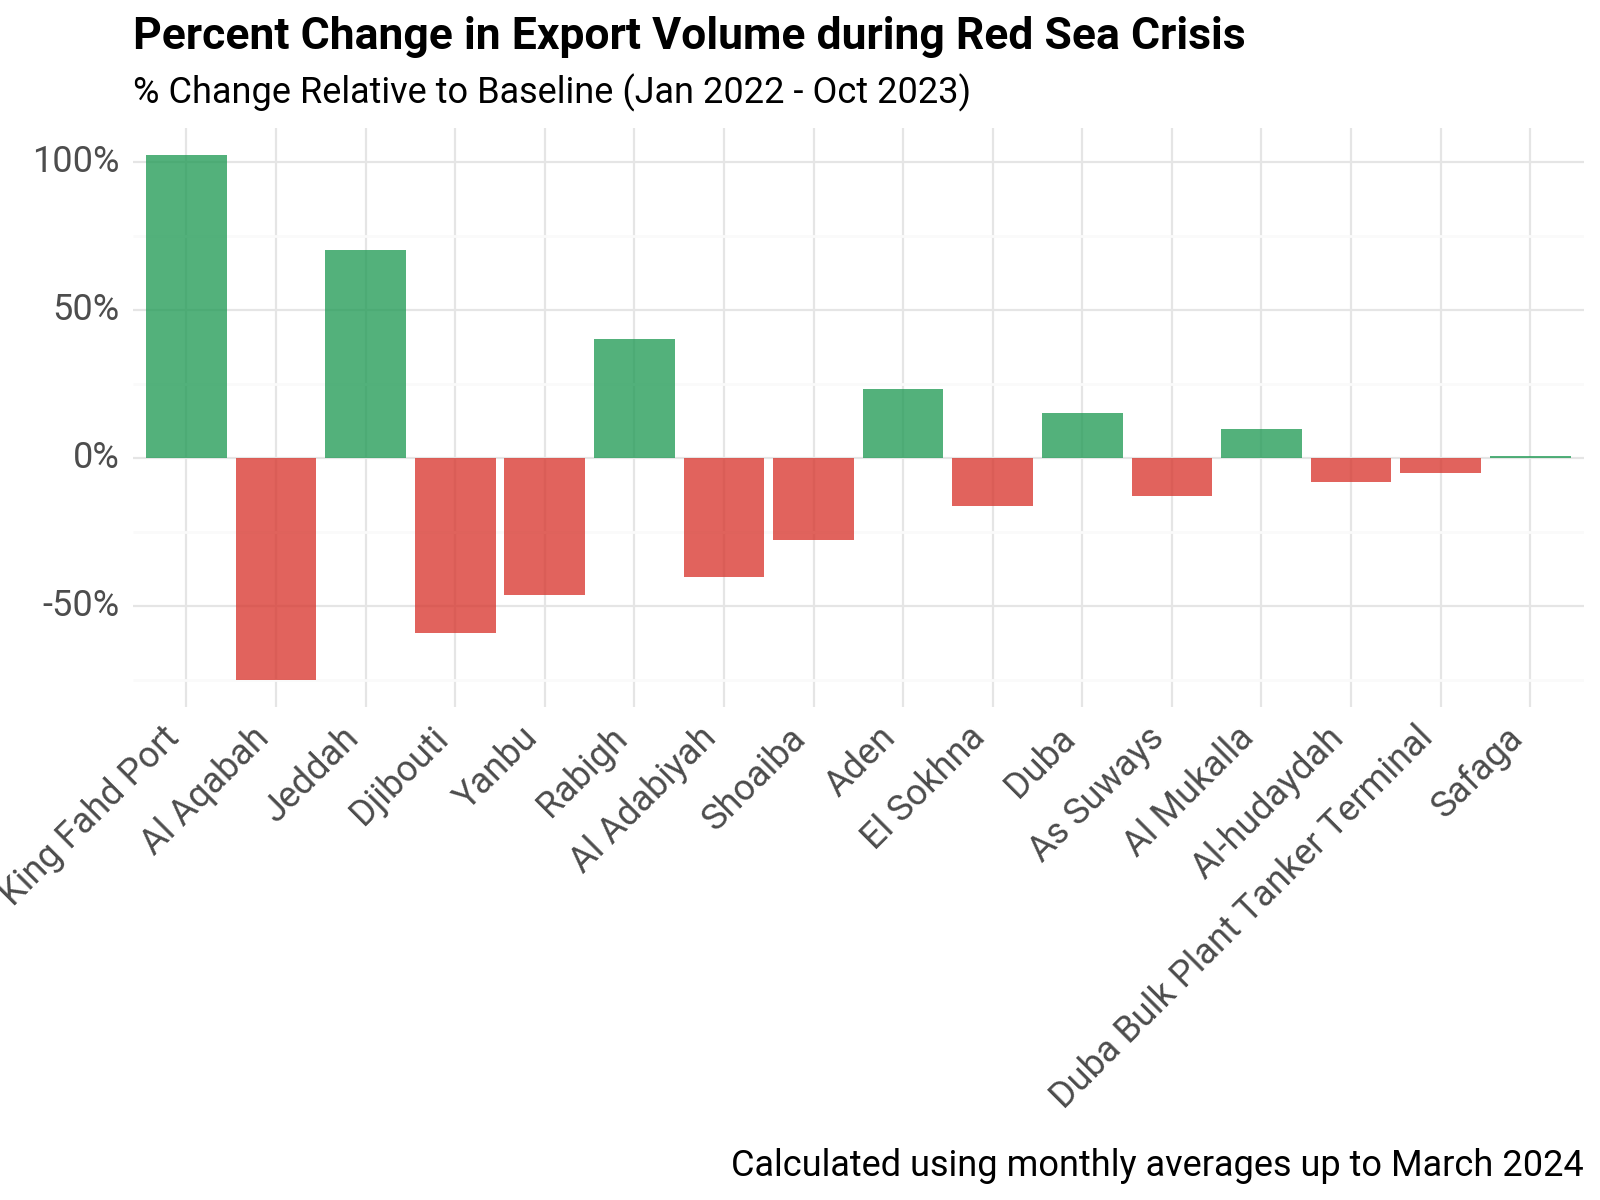

<Figure Size: (800 x 600)>

c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:587: PlotnineWarning: Saving 8 x 6 in image.
c:\WBG\Anaconda3\envs\rtmis\Lib\site-packages\plotnine\ggplot.py:588: PlotnineWarning: Filename: C:/Users/WB514197/Repos/red-sea-monitoring\reports\export-pct-change.jpeg


In [51]:
p4 = (
    ggplot(
        df_agg_pct_raw, aes(x="portname_cat", y="export", fill="export_direction")
    )  #
    + geom_bar(
        alpha=3 / 4,
        stat="identity",
        position="dodge2",
    )  #  fill="lightblue"
    + labs(
        x="",
        y="",
        title="Percent Change in Export Volume during Red Sea Crisis",
        subtitle="% Change Relative to Baseline (Jan 2022 - Oct 2023)",
        caption="Calculated using monthly averages up to March 2024",
        # caption="Calculated using monthly averages during Red Sea Crisis \n(Oct, 2023 - Mar 2024) and baseline period (Jan 2022 - Oct 2023)"
    )
    + theme_minimal()
    + theme(
        text=element_text(family="Roboto", size=13),
        plot_title=element_text(family="Roboto", size=16, weight="bold"),
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position="none",
    )
    + scale_y_continuous(labels=percent_format())
    + scale_fill_manual(values=["#d73027", "#1a9850"])
)
display(p4)
p4.save(filename=join(charts_dir, "export-pct-change.jpeg"), dpi=300)

Save tables with and without formatting

In [52]:
df_agg = df_agg.reset_index()
df_agg_pct = df_agg_pct.reset_index()

df_agg_pct = df_agg_pct[
    [
        "country",
        "portname",
        "period",
        "import_cargo",
        "export_cargo",
        "import_tanker",
        "export_tanker",
        "import",
        "export",
    ]
]

In [53]:
df_agg.rename(
    columns={
        "country": "Country",
        "portname": "Port",
        "period": "Period",
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)
df_agg_pct.rename(
    columns={
        "country": "Country",
        "portname": "Port",
        "period": "Period",
        "import_cargo": "Cargo Import",
        "export_cargo": "Cargo Export",
        "import_tanker": "Tanker Import",
        "export_tanker": "Tanker Export",
        "import": "Total Import",
        "export": "Total Export",
    },
    inplace=True,
)

In [54]:
with pd.ExcelWriter(
    join(output_dir, "tables", f'summary-tables-ports-{time.strftime("%Y_%m_%d")}.xlsx')
) as writer:
    table.to_excel(writer, sheet_name="Ports Summary")
    table2.to_excel(writer, sheet_name="Ports % Change")
    df_agg.to_excel(writer, sheet_name="Ports Summary (Raw)")
    df_agg_pct.to_excel(writer, sheet_name="Ports % Change (Raw)")